# 🏎️ COTA RACE 1 TELEMETRY ANALYSIS

- **Built by:** Michael Neang
- **Dataset:** R1 COTA, Raw Telemetry + Lap Times
- **Pipeline:** Data loading → Lap detection → Telemetry alignment → Aggregation → Visualization
- **Goal:** Extract driving performance per lap + prep for modeling or event comparison


In [11]:
# Ensure the src/ directory (where our pipeline lives) is in the Python path
import sys
sys.path.append("../src")

# Import the main pipeline functions
import preprocess

# General data libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots display in the notebook
%matplotlib inline
sns.set_style("whitegrid")  # Clean visual theme


In [12]:
# Define path to raw COTA Race 1 data (relative to this notebook)
BASE_PATH = "../data/COTA_Race1"

# Run the end-to-end pipeline, which performs:
# 1. Load telemetry and lap timing CSVs
# 2. Build lap time windows per vehicle/lap
# 3. Pivot telemetry long -> wide format
# 4. Assign laps to each telemetry sample based on timestamp
# 5. Create aggregated stats per lap (max speed, avg throttle, etc.)
outputs = preprocess.build_pipeline_outputs(BASE_PATH)


✅ Loaded telemetry: R1_cota_telemetry_data.csv  rows=2352983
✅ Loaded lap_time: COTA_lap_time_R1.csv  rows=631
✅ Loaded lap_start: COTA_lap_start_time_R1.csv  rows=631
✅ Loaded lap_end: COTA_lap_end_time_R1.csv  rows=631


In [13]:
# This DataFrame shows the start/end timestamps per lap for each vehicle
lap_windows = outputs["lap_windows"]
lap_windows.head()


,vehicle_id,outing,lap,start_time,end_time
0,GR86-002-2,0,1,2025-04-26 20:48:19.687000+00:00,2025-04-26 20:54:54.445000+00:00
1,GR86-002-2,0,2,2025-04-26 20:54:54.446000+00:00,2025-04-26 21:43:12.083000+00:00
2,GR86-004-78,0,1,2025-04-26 20:51:15.164000+00:00,2025-04-26 20:54:55.534000+00:00
3,GR86-004-78,0,2,2025-04-26 20:54:55.535000+00:00,2025-04-26 20:58:39.173000+00:00
4,GR86-004-78,0,3,2025-04-26 20:58:39.174000+00:00,2025-04-26 21:01:13.773000+00:00


In [14]:
# Telemetry pivoted to wide format (one row per timestamp per vehicle)
telemetry_wide = outputs["telemetry_wide"]
telemetry_wide.head()


,timestamp,vehicle_id,outing,Steering_Angle,accx_can,accy_can,ath,gear,nmot,pbrake_f,pbrake_r,speed
0,2025-04-24 20:46:58.045000+00:00,GR86-002-2,0.0,0.2,-0.048,0.019,4.30,0.0,NaN,0.0,0.0,NaN
1,2025-04-24 20:46:58.091000+00:00,GR86-002-2,0.0,0.2,-0.051,0.012,4.29,0.0,NaN,0.0,0.0,NaN
2,2025-04-24 20:46:58.135000+00:00,GR86-002-2,0.0,0.2,-0.050,0.026,4.26,0.0,1082.0,0.0,0.0,21.54
3,2025-04-24 20:46:58.179000+00:00,GR86-002-2,0.0,0.2,-0.053,0.009,4.26,0.0,NaN,0.0,0.0,NaN
4,2025-04-24 20:46:58.222000+00:00,GR86-002-2,0.0,0.2,-0.066,0.019,4.24,0.0,NaN,0.0,0.0,NaN


In [15]:
# Each telemetry row is now tagged with lap number (based on timestamp)
telemetry_with_laps = outputs["telemetry_with_laps"]
telemetry_with_laps.head()


,timestamp,vehicle_id,outing,Steering_Angle,accx_can,accy_can,ath,gear,nmot,pbrake_f,pbrake_r,speed,lap,start_time_key,start_time,end_time


In [16]:
# One row per lap per vehicle, with aggregates like max speed, avg throttle, etc.
lap_agg = outputs["lap_aggregates"]
lap_agg.head()


,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r


/tmp/ipykernel_1692/2356767108.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Vehicle")


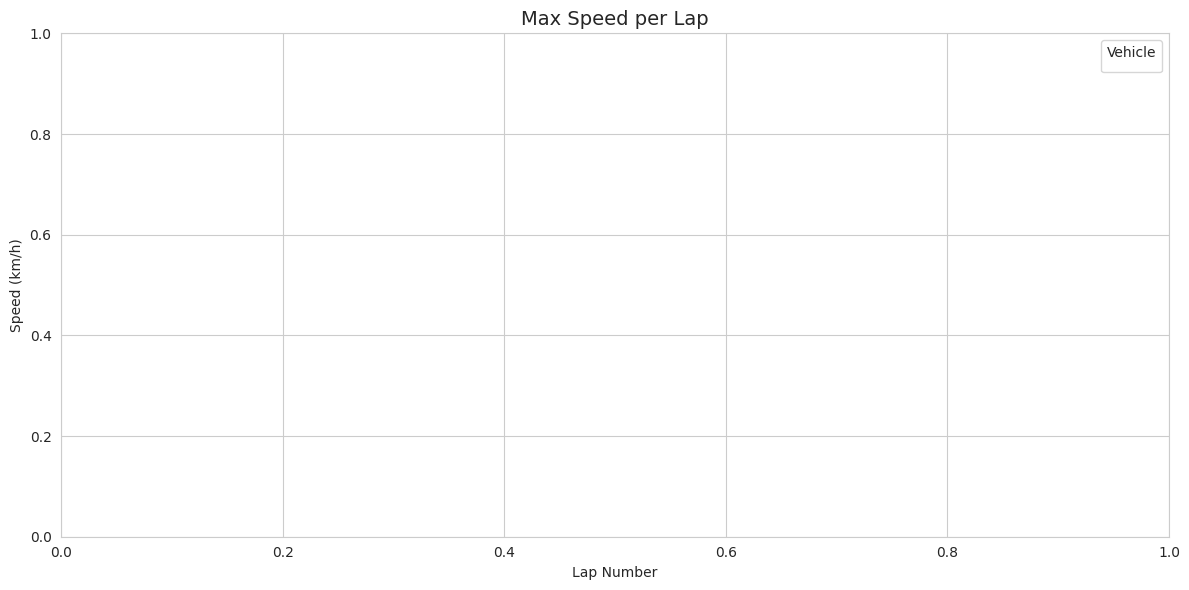

In [17]:
# Plot top speed achieved in each lap by each car
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=lap_agg,
    x="lap",
    y="max_speed",
    hue="vehicle_id",
    marker="o"
)
plt.title("Max Speed per Lap", fontsize=14)
plt.ylabel("Speed (km/h)")
plt.xlabel("Lap Number")
plt.legend(title="Vehicle")
plt.tight_layout()
plt.show()


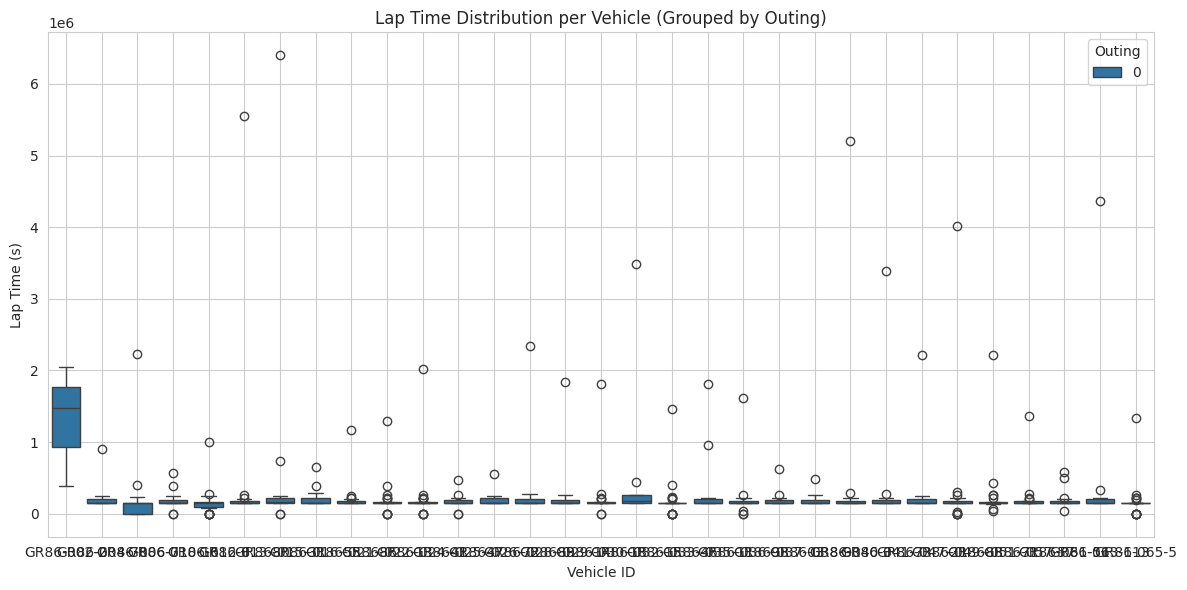

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get lap time data (already loaded as dfs["lap_time"] if you're using build_pipeline_outputs)
lap_times = outputs["lap_time_raw"].copy()

# Clean timestamps
lap_times["timestamp"] = pd.to_datetime(lap_times["timestamp"], errors="coerce")

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_times, x="vehicle_id", y="value", hue="outing")
plt.title("Lap Time Distribution per Vehicle (Grouped by Outing)")
plt.ylabel("Lap Time (s)")
plt.xlabel("Vehicle ID")
plt.legend(title="Outing")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Select a single vehicle/outing for clarity
df = outputs["telemetry_with_laps"]
sample = df[(df["vehicle_id"] == df["vehicle_id"].unique()[0])].copy()

plt.figure(figsize=(14, 6))
sns.lineplot(data=sample, x="timestamp", y="Speed", hue="lap", palette="turbo", legend=False)
plt.title("Speed Over Time — Colored by Lap")
plt.xlabel("Timestamp")
plt.ylabel("Speed (km/h)")
plt.grid(True)
plt.tight_layout()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
lap_agg = outputs["lap_aggregates"]

plt.figure(figsize=(12, 6))
sns.lineplot(data=lap_agg, x="lap", y="avg_throttle", hue="vehicle_id", marker="o")
plt.title("Average Throttle per Lap")
plt.xlabel("Lap")
plt.ylabel("Avg Throttle %")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Repeat for brake

In [ ]:
!sudo apt-get update
!sudo apt-get install -y texlive-xetex pandoc


Get:1 https://dl.yarnpkg.com/debian stable InRelease
Get:2 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble InRelease [3600 B]
Get:3 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease [3961 B]
Get:4 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]      
Get:5 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:6 https://dl.yarnpkg.com/debian stable/main amd64 Packages [11.8 kB]
Get:7 https://dl.yarnpkg.com/debian stable/main all Packages [11.8 kB]         
Get:8 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble/main amd64 Packages [67.3 kB]
Get:9 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble/main all Packages [643 B]
Get:10 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable/main amd64 Packages [4557 B]
Get:11 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1643 kB]
Get:12 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [

In [20]:
!jupyter nbconvert --to pdf test_loader.ipynb


[NbConvertApp] Converting notebook test_loader.ipynb to pdf
[NbConvertApp] Support files will be in test_loader_files/
[NbConvertApp] Making directory ./test_loader_files
[NbConvertApp] Writing 141981 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 160862 bytes to test_loader.pdf
